In [1]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
import FinanceDataReader as fdr

### 지수로 종목 가격 예측

In [3]:
class PatternFinder():
    def __init__(self, period=5):
        self.period = period
        self.kospi = pd.read_csv('코스피.csv')
        self.kosdaq = pd.read_csv('코스닥.csv') 
        self.code_kospi = fdr.StockListing('KOSPI').Code.values
        self.code_kosdaq = fdr.StockListing('KOSDAQ').Code.values

    def set_stock(self, code: str):
        self.code = code
        self.data = fdr.DataReader(code)
        self.close = self.data['Close']
        self.change = self.data['Change']
        return self.data

    def search(self, start_date, end_date, threshold=0.98):
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)

        # Condition to use KOSPI or KOSDAQ data based on the stock code
        if self.code in self.code_kospi:
            base_df = self.kospi
        elif self.code in self.code_kosdaq:
            base_df = self.kosdaq
        else:
            raise ValueError("Stock code not found in KOSPI or KOSDAQ listings")
    
        # Convert the 'Date' column of the chosen dataframe to datetime objects
        base_df['Date'] = pd.to_datetime(base_df['Date'])
    
        # Filter the chosen dataframe by date range and select the 'Close' column
        base = base_df[(base_df['Date'] >= start_date) & (base_df['Date'] <= end_date)]['Close']
    
        # Normalize the data
        self.base_norm = (base - base.min()) / (base.max() - base.min())
        self.base = base
    
        window_size = len(base)
        moving_cnt = len(self.data) - window_size - self.period - 1
        cos_sims = self.__cosine_sims(moving_cnt, window_size)
    
        self.window_size = window_size
        cos_sims = cos_sims[cos_sims > threshold]
        return cos_sims
        
    
    def __cosine_sims(self, moving_cnt, window_size):
        def cosine_similarity(x, y):
            return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))
        
        # 유사도 저장 딕셔너리
        sim_list = []

        for i in range(moving_cnt):
            target = self.close[i:i+window_size]

            # Normalize
            target_norm = (target - target.min()) / (target.max() - target.min())

            # 코사인 유사도 저장
            cos_similarity = cosine_similarity(self.base_norm, target_norm)

            # 코사인 유사도 <- i(인덱스), 시계열데이터 함께 저장
            sim_list.append(cos_similarity)
        return pd.Series(sim_list).sort_values(ascending=False)

    
    def plot_pattern(self, idx, period=5):
        if period != self.period:
            self.period = period
            
        top = self.close[idx:idx+self.window_size+period]
        top_norm = (top - top.min()) / (top.max() - top.min())

        plt.plot(self.base_norm.values, label='base')
        plt.plot(top_norm.values, label='target')
        plt.axvline(x=len(self.base_norm)-1, c='r', linestyle='--')
        plt.axvspan(len(self.base_norm.values)-1, len(top_norm.values)-1, facecolor='yellow', alpha=0.3)
        plt.legend()
        plt.show()
        
        
        preds = self.change[idx+self.window_size: idx+self.window_size+period]
        display(preds)
        print(f'pred: {round(preds.mean(),5)*100} % ')
        return f'pred: {round(preds.mean(),5)*100} %'

    
    def stat_prediction(self, result, period=5):
        idx_list = list(result.keys())
        mean_list = []
        for idx in idx_list:
            pred = self.change[idx+self.window_size: idx+self.window_size+period]
            mean_list.append(pred.mean())
        return np.array(mean_list)

Similarity Results:
2236    0.990063
2292    0.989298
2291    0.989167
2235    0.987753
3166    0.987496
2727    0.986758
4029    0.985577
5554    0.985544
5553    0.985505
860     0.985464
274     0.985306
1784    0.985150
3236    0.984959
3167    0.984600
2938    0.984503
1611    0.984398
5093    0.984328
463     0.984228
1190    0.983767
861     0.983202
2726    0.982994
243     0.982890
3682    0.982855
1785    0.982791
275     0.982480
464     0.982254
5649    0.982038
2201    0.981623
855     0.980062
4739    0.980029
dtype: float64


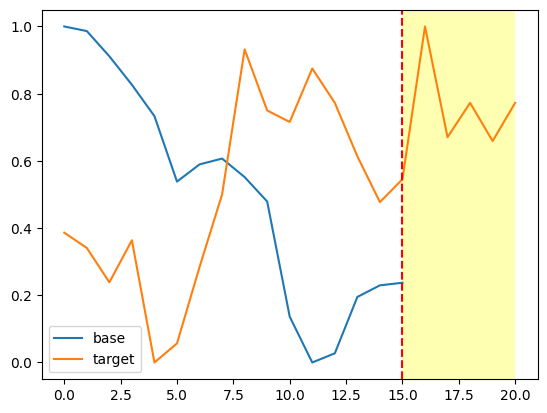

Date
1999-08-10    0.111111
1999-08-11   -0.072500
1999-08-12    0.024259
1999-08-13   -0.026316
1999-08-16    0.027027
Name: Change, dtype: float64

pred: 1.272 % 
Statistical Prediction Results:
[ 0.0089963   0.00165685  0.01632798  0.00590773 -0.00160794 -0.00149091
  0.0065294   0.0019788   0.00248037  0.02208073 -0.01342171  0.0058981
  0.00544566  0.00137022  0.00087233  0.00446746 -0.01185116 -0.02340435
  0.02063365  0.02064518  0.00029578  0.00525219 -0.00100161  0.01104175
  0.01286579 -0.02612835 -0.00572543  0.00933468 -0.00797078 -0.01418022]


In [4]:
# Define your PatternFinder class here (with the modifications)

# Create an instance of the PatternFinder class
pattern_finder = PatternFinder()

# Set the stock code you want to analyze (for example, Samsung Electronics)
stock_code = "005930"  # Replace with the KOSPI stock code you want to analyze
pattern_finder.set_stock(stock_code)

# Define your start_date and end_date as datetime objects
start_date = pd.to_datetime("2019-07-22")
end_date = pd.to_datetime("2019-08-12")

# Perform similarity search using KOSPI data as the base
cosine_sims = pattern_finder.search(start_date, end_date, threshold=0.98)

# Print the results or perform further analysis
print("Similarity Results:")
print(cosine_sims)

# Plot a similar pattern (you can replace 0 with the index you want to plot)
pattern_finder.plot_pattern(0)

# Perform statistical prediction based on the results
period = 5
mean_list = pattern_finder.stat_prediction(cosine_sims, period)
print("Statistical Prediction Results:")
print(mean_list)


### 실제수익률 비교

In [5]:
# Set the stock code and date range
stock_code = "005930"  # Replace with your stock code
start_date = pd.to_datetime("2019-07-22")
end_date = pd.to_datetime("2019-08-12")

# Load the stock data
stock_data = fdr.DataReader(stock_code, start_date, end_date)

# Calculate the actual returns
stock_returns = stock_data['Close'].pct_change().dropna()  # Daily stock returns

# Calculate the cumulative returns
stock_cumulative_returns = (stock_returns + 1).cumprod() 

# Print the cumulative returns
print("실제 수익률:")
print(f'{round(stock_cumulative_returns[-1]-stock_cumulative_returns[0],3)*100}'+'%')

실제 수익률:
-7.6%


In [11]:
class PatternFinder():
    def __init__(self, period=5):
        self.period = period
        self.kospi = pd.read_csv('코스피.csv')
        self.kosdaq = pd.read_csv('코스닥.csv') 
        self.code_kospi = fdr.StockListing('KOSPI').Code.values
        self.code_kosdaq = fdr.StockListing('KOSDAQ').Code.values

    def set_stock(self, code: str):
        self.code = code
        self.data = fdr.DataReader(code)
        self.close = self.data['Close']
        self.change = self.data['Change']
        return self.data

    def search(self, start_date, end_date, threshold=0.98):
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)

        # Condition to use KOSPI or KOSDAQ data based on the stock code
        if self.code in self.code_kospi:
            base_df = self.kospi
        elif self.code in self.code_kosdaq:
            base_df = self.kosdaq
        else:
            raise ValueError("Stock code not found in KOSPI or KOSDAQ listings")
    
        # Convert the 'Date' column of the chosen dataframe to datetime objects
        base_df['Date'] = pd.to_datetime(base_df['Date'])
    
        # Filter the chosen dataframe by date range and select the 'Close' column
        base = base_df[(base_df['Date'] >= self.start_date) & (base_df['Date'] <= self.end_date)]['Close']
    
        # Normalize the data
        self.base_norm = (base - base.min()) / (base.max() - base.min())
        self.base = base
    
        window_size = len(base)
        moving_cnt = len(self.data) - window_size - self.period - 1
        cos_sims = self.__cosine_sims(moving_cnt, window_size)
    
        self.window_size = window_size
        cos_sims = cos_sims[cos_sims > threshold]
        return cos_sims
        
    
    def __cosine_sims(self, moving_cnt, window_size):
        def cosine_similarity(x, y):
            return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))
        
        # 유사도 저장 딕셔너리
        sim_list = []

        for i in range(moving_cnt):
            target = self.close[i:i+window_size]

            # Normalize
            target_norm = (target - target.min()) / (target.max() - target.min())

            # 코사인 유사도 저장
            cos_similarity = cosine_similarity(self.base_norm, target_norm)

            # 코사인 유사도 <- i(인덱스), 시계열데이터 함께 저장
            sim_list.append(cos_similarity)
        return pd.Series(sim_list).sort_values(ascending=False)

    
    def plot_pattern(self, idx, period=5):
        if period != self.period:
            self.period = period
            
        top = self.close[idx:idx+self.window_size+period]
        top_norm = (top - top.min()) / (top.max() - top.min())

        plt.plot(self.base_norm.values, label='base')
        plt.plot(top_norm.values, label='target')
        plt.axvline(x=len(self.base_norm)-1, c='r', linestyle='--')
        plt.axvspan(len(self.base_norm.values)-1, len(top_norm.values)-1, facecolor='yellow', alpha=0.3)
        plt.legend()
        plt.show()
        
        
        preds = self.change[idx+self.window_size: idx+self.window_size+period]
        display(preds)
        print(f'pred: {round(preds.mean(),5)*100} % ')
        return f'pred: {round(preds.mean(),5)*100} %'

    
    def stat_prediction(self, result, period=5):
        idx_list = list(result.keys())
        mean_list = []
        for idx in idx_list:
            pred = self.change[idx+self.window_size: idx+self.window_size+period]
            mean_list.append(pred.mean())
        return np.array(mean_list)

In [12]:
class RealProfit:
    def __init__(self, pattern_finder):
        self.pattern_finder = pattern_finder  # PatternFinder 객체를 전달
        self.start_date = self.pattern_finder.start_date
        self.end_date = self.pattern_finder.end_date
        self.code = self.pattern_finder.code

    def calculate_profit(self):
        # start_date, end_date, code 정보를 활용하여 실제 수익률을 계산
        # 주식 데이터와 KOSPI 지수 데이터를 가져오고 수익률을 계산하는 등의 작업 수행
        start_date = pd.to_datetime(self.start_date)
        end_date = pd.to_datetime(self.end_date)
        
        stock_data = fdr.DataReader(self.code, start_date, end_date)
        stock_returns = stock_data['Close'].pct_change().dropna()  # Daily stock returns
        stock_cumulative_returns = (stock_returns + 1).cumprod() 

        print(f'실제수익률: {round(stock_cumulative_returns[-1]-stock_cumulative_returns[0], 5) * 100} % ')
        return f'{round(stock_cumulative_returns[-1]-stock_cumulative_returns[0], 5) * 100} %'


Similarity Results:
2236    0.990063
2292    0.989298
2291    0.989167
2235    0.987753
3166    0.987496
2727    0.986758
4029    0.985577
5554    0.985544
5553    0.985505
860     0.985464
274     0.985306
1784    0.985150
3236    0.984959
3167    0.984600
2938    0.984503
1611    0.984398
5093    0.984328
463     0.984228
1190    0.983767
861     0.983202
2726    0.982994
243     0.982890
3682    0.982855
1785    0.982791
275     0.982480
464     0.982254
5649    0.982038
2201    0.981623
855     0.980062
4739    0.980029
dtype: float64


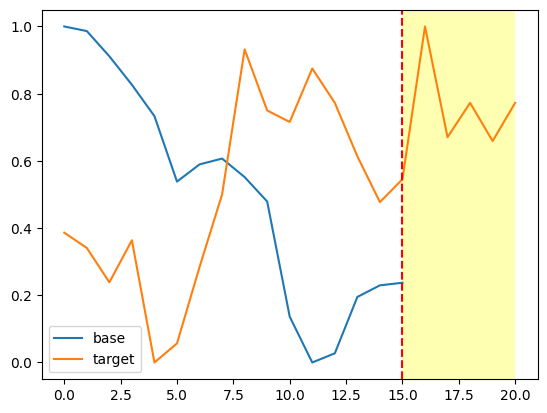

Date
1999-08-10    0.111111
1999-08-11   -0.072500
1999-08-12    0.024259
1999-08-13   -0.026316
1999-08-16    0.027027
Name: Change, dtype: float64

pred: 1.272 % 
Statistical Prediction Results:
[ 0.0089963   0.00165685  0.01632798  0.00590773 -0.00160794 -0.00149091
  0.0065294   0.0019788   0.00248037  0.02208073 -0.01342171  0.0058981
  0.00544566  0.00137022  0.00087233  0.00446746 -0.01185116 -0.02340435
  0.02063365  0.02064518  0.00029578  0.00525219 -0.00100161  0.01104175
  0.01286579 -0.02612835 -0.00572543  0.00933468 -0.00797078 -0.01418022]


In [20]:
# Define your PatternFinder class here (with the modifications)

# Create an instance of the PatternFinder class
pattern_finder = PatternFinder()

# Set the stock code you want to analyze (for example, Samsung Electronics)
stock_code = "005930"  # Replace with the KOSPI stock code you want to analyze
pattern_finder.set_stock(stock_code)

# Define your start_date and end_date as datetime objects
start_date = pd.to_datetime("2019-07-22")
end_date = pd.to_datetime("2019-08-12")

# Perform similarity search using KOSPI data as the base
cosine_sims = pattern_finder.search(start_date, end_date, threshold=0.98)

# Print the results or perform further analysis
print("Similarity Results:")
print(cosine_sims)

# Plot a similar pattern (you can replace 0 with the index you want to plot)
pattern_finder.plot_pattern(0)

# Perform statistical prediction based on the results
period = 5
mean_list = pattern_finder.stat_prediction(cosine_sims, period)
print("Statistical Prediction Results:")
print(mean_list)


In [21]:
real_profit_calculator = RealProfit(pattern_finder)
real_profit = real_profit_calculator.calculate_profit()

실제수익률: -7.627000000000001 % 
